In [1]:
!pip install gymnasium

Unable to create process using 'C:\Users\Nicholas Vella\anaconda3\python.exe "C:\Users\Nicholas Vella\anaconda3\Scripts\pip-script.py" install gymnasium'


In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
from typing import Sequence
from collections import namedtuple, deque
import itertools
import random
import copy
from itertools import count
import warnings
warnings.filterwarnings("ignore")

In [3]:
GAMMA = 0.99
BATCH_SIZE = 64
BUFFER_SIZE = 10000
MIN_REPLAY_SIZE = 5000
TAU = 0.01

In [4]:
env = gym.make("LunarLanderContinuous-v2")
obs, _ = env.reset()
episode_reward = 0.0

In [5]:
# Random noise generator: Taken from OpenAI baselines
class ActionNoise(object):
    def reset(self):
        pass

class OrnsteinUhlenbeckActionNoise(ActionNoise):
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [6]:
std_dev = 0.2
ou_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=float(std_dev) * np.ones(1))

In [7]:
T = lambda x: torch.as_tensor(x, dtype=torch.float32)
Ti = lambda x: torch.as_tensor(x, dtype=torch.int64)

In [8]:
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))

class Replay_memory():

    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize)
        self.rewards = deque(maxlen=50)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        self.memory.append(transition)

    def sample_batch(self):
        batch = random.sample(self.memory, self.batchsize)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32))
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.float32))
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1)
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32))
        return states, actions, rewards, dones, next_states

    def initialize(self):
        obs, _ = env.reset()
        for _ in range(self.minsize):
            action = self.env.action_space.sample()
            new_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                self.env.reset()
        return self

In [9]:
replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

In [10]:
# Policy/Actor Network
class PolicyNet(nn.Module):

    def __init__(self, input_size, hidden_units, output_size, pmin, pmax):
        super(PolicyNet, self).__init__()
        self.pmin = pmin
        self.pmax = pmax
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_units/2), output_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x) * self.pmax
        torch.clip_(x, self.pmin, self.pmax)
        return x

    def __call__(self, x):
        out = self.forward(x)
        return out

In [11]:
#Critic Network
class DQN(nn.Module):

    def __init__(self, input_size, hidden_units):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_units/2), 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = self.model(x)
        return x

    def __call__(self, state, action):
        out = self.forward(state, action)
        return out

In [12]:
obs_size = env.observation_space.shape[0]
act_size = env.action_space.shape[0]
hiddenlayers = 128
output_minrange = env.action_space.low
output_maxrange = env.action_space.high

In [13]:
actor = PolicyNet(obs_size, hiddenlayers, act_size, T(output_minrange), T(output_maxrange))
actor_target = copy.deepcopy(actor)
critic = DQN(obs_size + act_size, hiddenlayers)
critic_target = copy.deepcopy(critic)

In [14]:
actor_optimizer  = optim.AdamW(actor.parameters(), lr=0.0003)
critic_optimizer = optim.AdamW(critic.parameters(), lr=0.0003)

In [15]:
def update():
        states, actions, rewards, dones, next_states = replay_memory.sample_batch()

        ou_noise.reset()
        # Critic loss
        Qvals = critic(states, actions)
        with torch.no_grad():
            actions_ = actor_target(next_states)
            Qvals_ = critic_target(next_states, actions_)
            Qvals_[dones] = 0.0
            target = rewards + GAMMA * Qvals_
        critic_loss = F.smooth_l1_loss(target, Qvals)

        # Actor loss
        actor_loss = -critic(states, actor(states)).mean()

        # update networks
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # update target networks
        for target_param, param in zip(actor_target.parameters(), actor.parameters()):
            target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))

        for target_param, param in zip(critic_target.parameters(), critic.parameters()):
            target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))


In [16]:
returns = deque(maxlen=50)
all_rewards = []
all_episodes = []
for episode in count():
    state, _ = env.reset()
    episode_reward = 0
    done = False
    while not done:
        with torch.no_grad():
            action = actor(T(state)).numpy() + ou_noise()
        new_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        transition = Transition(state, action, reward, done, new_state)
        replay_memory.append(transition)
        update()
        state = new_state
        episode_reward += reward

    returns.append(episode_reward)
    score = np.mean(returns)
    all_rewards.append(score)
    all_episodes.append(episode)
    if episode > 0 and episode % 100 == 0:
        print(f'Episode: {episode}  Return: {episode_reward}  Average Return: {score}')
    if score >= 195:
        print(f'Solved! Episode: {episode}  Return: {episode_reward}  Average Return: {score}')
        break

Episode: 100  Return: -53.79213179803695  Average Return: -155.5637083440577
Episode: 200  Return: 214.38915223334843  Average Return: 53.68939589984377
Episode: 300  Return: 280.6725591432314  Average Return: 43.283860535647726
Episode: 400  Return: 245.89112855394222  Average Return: 134.08434213977333
Episode: 500  Return: -37.70700633315738  Average Return: 52.38660097001187
Episode: 600  Return: 185.43266273445943  Average Return: 130.7369915908122
Episode: 700  Return: 101.30325436365638  Average Return: 11.201570921807892
Episode: 800  Return: 48.92142777438278  Average Return: 141.57054524525284
Solved! Episode: 873  Return: 249.69365856816378  Average Return: 201.47756931219246


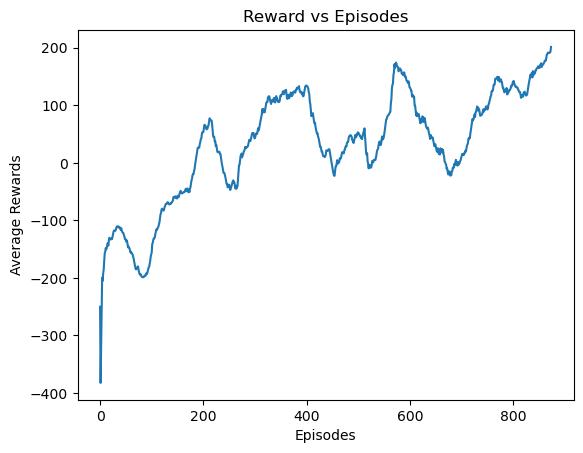

In [17]:
# Plot the returns versus trained episodes
plt.plot(all_episodes, all_rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.title('Reward vs Episodes')
plt.show()